In [1]:
import pandas as pd
import numpy as np

df_train = pd.read_csv("C:/Users/user/Documents/Data analytics/train.csv")
df_test = pd.read_csv("C:/Users/user/Documents/Data analytics/test.csv")
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [2]:
df_train.info(),
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [3]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [4]:
df_test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [5]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
df_test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [7]:
y = df_train['target'] 

length = len(df_train) 
df = pd.concat([df_train[df_train.columns[:-1]], df_test]) 

df.shape

(10876, 4)

In [8]:
df.drop( columns = ['keyword', 'location'], inplace = True)

df.head()

,id,text
0,1,Our Deeds are the Reason of this #earthquake M...
1,4,Forest fire near La Ronge Sask. Canada
2,5,All residents asked to 'shelter in place' are ...
3,6,"13,000 people receive #wildfires evacuation or..."
4,7,Just got sent this photo from Ruby #Alaska as ...


In [9]:
from nltk.tokenize import sent_tokenize, word_tokenize
import string
import re

In [10]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [11]:
def clean_tweet(text):
    
    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
 
    return text

# Clean text and add a new feature
df["clean_text"] = df["text"].apply(clean_tweet)

In [12]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer

TTokenizer = TweetTokenizer()

def tokenizeANDstem(text):
    tokens = TTokenizer.tokenize(text)    
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [13]:
#using tf-idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer 

TfIdf = TfidfVectorizer(tokenizer=tokenizeANDstem, max_features=3000)
x = TfIdf.fit_transform(df['clean_text'].tolist())

In [14]:
#split the data into training and testing set
df_train_transformed = x[:length] 
df_test_transformed = x[length:] 

df_train_transformed.shape, df_test_transformed.shape

((7613, 3000), (3263, 3000))

In [15]:
from sklearn.model_selection import train_test_split  

#split the training dataset into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(df_train_transformed, y, test_size = 0.2, random_state = 101) 

Accuracy = 0.7570584372948129
F1-Score = 0.6209016393442623
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       892
           1       0.88      0.48      0.62       631

    accuracy                           0.76      1523
   macro avg       0.80      0.72      0.72      1523
weighted avg       0.79      0.76      0.74      1523



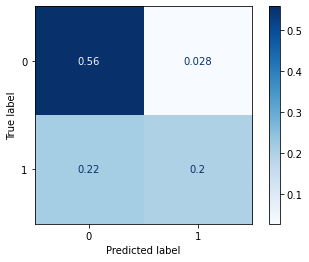

In [16]:
#Random forest classifier model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt

rfc = RandomForestClassifier(max_features = 'sqrt', max_depth=16, min_samples_leaf =1, 
                             min_samples_split = 2, n_estimators = 34, random_state=101)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
print("Accuracy = {}".format(accuracy))
print("F1-Score = {}".format(f1))

print(classification_report(y_test, y_pred))

plot_confusion_matrix(rfc, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# define models and parameters
model = LogisticRegression(random_state=101)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
c_values = [30, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=4, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.800331 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


In [18]:
# Cross Validation
model = LogisticRegression(penalty='l2', solver='newton-cg', C=1.0, random_state=101)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train,y_train, scoring='accuracy', cv=5)
scores

array([0.80295567, 0.77914614, 0.79474548, 0.81527094, 0.81116585])

Accuracy = 0.7971109652002626
F1-Score = 0.7405541561712846
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       892
           1       0.79      0.70      0.74       631

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



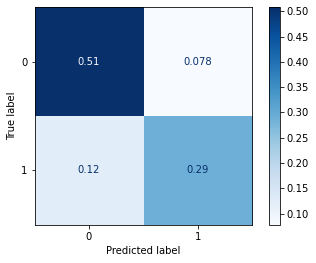

In [19]:
#Logistic Regression Model
logreg = LogisticRegression(penalty='l2', solver='newton-cg', C=1.0, random_state=101)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
print("Accuracy = {}".format(accuracy))
print("F1-Score = {}".format(f1))

print(classification_report(y_test, y_pred))

plot_confusion_matrix(logreg, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')